# INTRA PATIENT PERFORMANCE EVALUATION

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import tensorflow as tf
import tensorflow_addons as tfa
from os.path import join as osj
import pandas as pd
import seaborn as sns
import random
import pickle
import os


## Load and transform performance results

In [38]:
def load_results(m):
    with open(osj(f"../results_dp/{m}/intrapatient_results.pkl"), 'rb') as f:
        results = pickle.load(f)
    with open(osj(f"../results_dp/{m}/intrapatient_loss.pkl"), 'rb') as f:
        loss = pickle.load(f)
    return results, loss

Transforming the results and losses into dataframes for evaluation.

In [39]:
dp_methods = ["laplace", "bounded_n", "gaussian_a"]
loss_records = []
result_records = []

for mechanism in dp_methods:

    # Load results and loss per mechanism
    mechanism_results, mechanism_loss = load_results(mechanism)

    # Extract loss
    for epsilon, deltas in mechanism_loss.items():
        for delta, epochs in deltas.items():

            last_epoch = max(epochs.keys()) if epochs else None  
            if last_epoch is None:
                continue 
            
            batches = epochs[last_epoch]
            last_batch = max(batches.keys()) if batches else None  
            if last_batch is None:
                continue
            
            loss = batches[last_batch]
            loss_records.append({
                "Model": f"Intra-{mechanism}",
                "Epsilon": epsilon,
                "Delta": delta,
                "Loss": loss
            })

    # ALL EPSILON VALUES
    # hp_epsilon_values = [0.001, 0.01, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
    #                             0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 
    #                     1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91, 2.01]
    # hp_delta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # TRAINED EPSILON VALUES
    hp_epsilon_values = [0.001, 0.01, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]
    

    dict_mechanism_results = {epsilon: mechanism_results[epsilon] for epsilon in hp_epsilon_values if epsilon in mechanism_results}

    # Extract results
    for epsilon, deltas in dict_mechanism_results.items():
        for delta, epochs in deltas.items():
            if epochs is None:
                continue
            else:
                for epoch, metrics in epochs.items():
                    for metric, values in metrics.items():
                        if metric == "avg_acc":
                            continue
                        else:
                            result_records.append({"Model": f"Intra-{mechanism}", "Epsilon": epsilon, "Delta": delta, "Epoch": epoch, "Metric": metric, "F": values[0], "N": values[1], "S": values[2], "V": values[3]})


df_results = pd.DataFrame(result_records)
df_losses = pd.DataFrame(loss_records)
    

In [40]:
df_results

,Model,Epsilon,Delta,Epoch,Metric,F,N,S,V
0,Intra-laplace,0.001,0.1,9,acc,0.996040,0.969307,0.978218,0.994059
1,Intra-laplace,0.001,0.1,9,sens,0.750000,0.985189,0.468085,0.942029
2,Intra-laplace,0.001,0.1,9,spec,0.997510,0.822335,0.990370,0.997875
3,Intra-laplace,0.001,0.1,9,prec,0.642857,0.980885,0.536585,0.970149
4,Intra-laplace,0.001,0.1,9,neg_pred_value,0.998505,0.857142,0.987367,0.995758
...,...,...,...,...,...,...,...,...,...
42385,Intra-gaussian_a,0.910,1.0,99,neg_pred_value,1.000000,0.995192,1.000000,1.000000
42386,Intra-gaussian_a,0.910,1.0,99,false_pos_rate,0.000500,0.000000,0.000000,0.000000
42387,Intra-gaussian_a,0.910,1.0,99,false_neg_rate,0.000000,0.000552,0.000000,0.000000
42388,Intra-gaussian_a,0.910,1.0,99,false_det_rate,0.050000,0.000000,0.000000,0.000000


In [41]:
# Adding anothere column with the class averages for all metrics
df_results.loc[:,"class_average"] = df_results[["F", "N", "S", "V"]].mean(axis=1)

Filter for only last epoch to reduce the dataframe size (skip, if all epochs are needed)

In [42]:
df_results_last = df_results.copy()
df_results_last = df_results_last[df_results_last['Epoch'] == 99]

In [43]:
df_results_last.drop(columns=["Epoch"], inplace=True)
df_results_last

,Model,Epsilon,Delta,Metric,F,N,S,V,class_average
81,Intra-laplace,0.001,0.1,acc,0.996040,0.962376,0.972426,0.991238,0.980520
82,Intra-laplace,0.001,0.1,sens,0.416667,0.985197,0.410638,0.875912,0.672104
83,Intra-laplace,0.001,0.1,spec,0.999502,0.750000,0.985808,0.999628,0.933735
84,Intra-laplace,0.001,0.1,prec,0.833333,0.973456,0.408034,0.994200,0.802256
85,Intra-laplace,0.001,0.1,neg_pred_value,0.996524,0.844827,0.985958,0.991049,0.954590
...,...,...,...,...,...,...,...,...,...
42385,Intra-gaussian_a,0.910,1.0,neg_pred_value,1.000000,0.995192,1.000000,1.000000,0.998798
42386,Intra-gaussian_a,0.910,1.0,false_pos_rate,0.000500,0.000000,0.000000,0.000000,0.000125
42387,Intra-gaussian_a,0.910,1.0,false_neg_rate,0.000000,0.000552,0.000000,0.000000,0.000138
42388,Intra-gaussian_a,0.910,1.0,false_det_rate,0.050000,0.000000,0.000000,0.000000,0.012500


In [ ]:
# f1_results = df_results[df_results["Metric"] == "f1_score"]
# f1_results

,Model,Epsilon,Delta,Epoch,Metric,F,N,S,V,class_average
8,Intra-laplace,0.001,0.1,9,f1_score,0.692308,0.983032,0.500000,0.955882,0.782806
17,Intra-laplace,0.001,0.1,19,f1_score,0.350877,0.969158,0.403846,0.942857,0.666685
26,Intra-laplace,0.001,0.1,29,f1_score,0.375000,0.983152,0.455696,0.958491,0.693085
35,Intra-laplace,0.001,0.1,39,f1_score,0.583333,0.982675,0.295082,0.942529,0.700905
44,Intra-laplace,0.001,0.1,49,f1_score,0.736842,0.980016,0.375000,0.963235,0.763773
...,...,...,...,...,...,...,...,...,...,...
14003,Intra-gaussian_a,0.061,1.0,59,f1_score,1.000000,0.999560,0.983607,1.000000,0.995792
14012,Intra-gaussian_a,0.061,1.0,69,f1_score,0.983607,0.999505,0.983936,1.000000,0.991762
14021,Intra-gaussian_a,0.061,1.0,79,f1_score,1.000000,0.999368,0.983936,0.997401,0.995176
14030,Intra-gaussian_a,0.061,1.0,89,f1_score,0.980926,0.999780,0.984955,1.000000,0.991415


## Loss evaluation

In [8]:
df_losses

,Model,Epsilon,Delta,Loss
0,Intra-laplace,0.001,0.1,0.013980
1,Intra-laplace,0.001,0.2,0.068355
2,Intra-laplace,0.001,0.3,0.007827
3,Intra-laplace,0.001,0.4,0.006639
4,Intra-laplace,0.001,0.5,0.006686
...,...,...,...,...
186,Intra-gaussian_a,0.061,0.9,0.006401
187,Intra-gaussian_a,0.061,1.0,0.006051
188,Intra-gaussian_a,0.071,0.1,0.007440
189,Intra-gaussian_a,0.071,0.2,0.006973


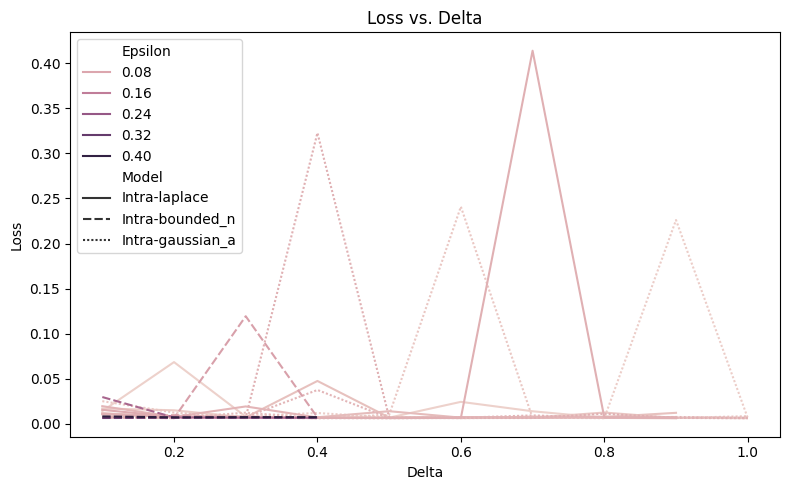

In [9]:
plt.figure(figsize=(8, 5))

sns.lineplot( 
    data = df_losses,
    x ="Delta", 
    y = "Loss", 
    hue = "Epsilon",
    style = "Model"
)

plt.xlabel("Delta")
plt.ylabel("Loss")
plt.title("Loss vs. Delta")
plt.legend()
plt.tight_layout()
plt.show()

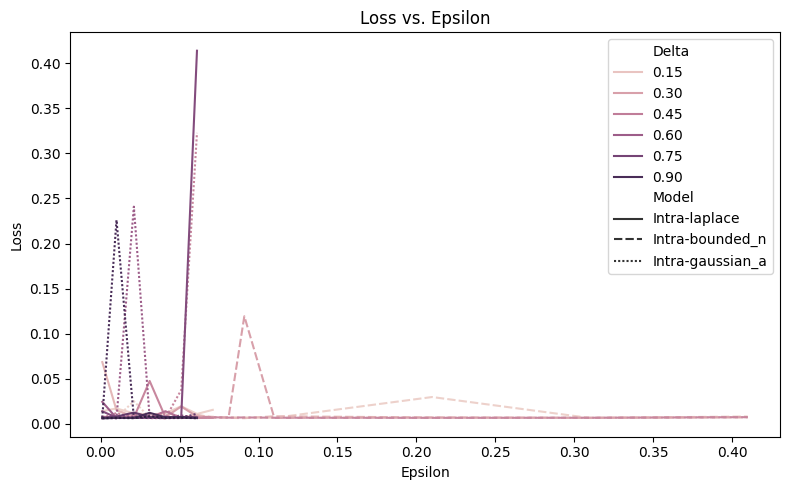

In [10]:
plt.figure(figsize=(8, 5))

sns.lineplot( 
    data = df_losses,
    x ="Epsilon", 
    y = "Loss", 
    hue = "Delta",
    style = "Model"
)

plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.title("Loss vs. Epsilon")
plt.legend()
plt.tight_layout()
plt.show()

## Performance evaluation

In [44]:
df_results_f1 = df_results_last[df_results_last["Metric"] == "f1_score"]

#### on average

In [45]:
# ---- Best in total ----
# Get the best setup for the model
best_total = df_results_f1.loc[df_results_f1["class_average"].idxmax()]
# best_total
# --> 
# Model            Intra-laplace
# Epsilon                  0.051
# Delta                      0.8
# Metric                f1_score
# F                          1.0
# N                          1.0
# S                          1.0
# V                          1.0
# class_average              1.0

# Get the n best setups for the model
best_n = df_results_f1.nlargest(15, "class_average")
# best_n
# --> TOP 14 have 1.0 for everything 



# ---- Worst in total ----
# Get the worst setup for the model
last_total = df_results_f1.loc[df_results_f1["class_average"].idxmin()]
# last_total
# --> 
# Model            Intra-laplace
# Epsilon                  0.001
# Delta                      0.0
# Metric                f1_score
# F                          NaN
# N                     0.906463
# S                     0.033389
# V                     0.052938
# class_average          0.33093

# Get the n worst setups for the model
last_n = df_results_f1.nsmallest(5, "class_average")
# last_n
# --> TOP 14 have 1.0 for everything 


In [46]:
# best_total
# best_n

# last_total
last_n

,Model,Epsilon,Delta,Metric,F,N,S,V,class_average
989,Intra-laplace,0.001,0.0,f1_score,NaN,0.906463,0.033389,0.052938,0.330930
4949,Intra-laplace,0.041,0.0,f1_score,NaN,0.888254,0.062016,0.277078,0.409116
6929,Intra-laplace,0.061,0.0,f1_score,0.148148,0.948170,0.070340,0.609668,0.444082
1979,Intra-laplace,0.010,0.0,f1_score,NaN,0.928191,NaN,0.010695,0.469443
7919,Intra-laplace,0.071,0.0,f1_score,0.166667,0.961799,0.067416,0.805085,0.500242


In [47]:
attack_setups = best_n[["Model", "Epsilon", "Delta"]].drop_duplicates() # 15 best setups (since all have 1.0 for everything)
attack_setups = pd.concat([attack_setups, last_n[["Model", "Epsilon", "Delta"]]], ignore_index=True) # worst 5 setups
len(attack_setups) 
# 20 in total

20

#### on average (all metrics)

In [48]:
relevant_metrics = ["f1_score", "acc", "sens", "spec", "prec"]

# ---- Best in total (all metrics) ----
best_keys = best_n[["Model", "Epsilon", "Delta"]]

mask_best = df_results_last.set_index(["Model", "Epsilon", "Delta"]).index.isin(best_keys.set_index(["Model", "Epsilon", "Delta"]).index)
best_keys_details = df_results_last[mask_best]
best_keys_details = best_keys_details[best_keys_details["Metric"].isin(relevant_metrics)]


# ---- Last in total (all metrics) ----
last_key = last_n[["Model", "Epsilon", "Delta"]]

mask_last = df_results_last.set_index(["Model", "Epsilon", "Delta"]).index.isin(last_key.set_index(["Model", "Epsilon", "Delta"]).index)
last_key_details = df_results_last[mask_last]
last_key_details = last_key_details[last_key_details["Metric"].isin(relevant_metrics)]

In [18]:
best_keys_details

,Model,Epsilon,Delta,Metric,F,N,S,V,class_average
5661,Intra-laplace,0.051,0.8,acc,1.0,1.0,1.0,1.0,1.0
5662,Intra-laplace,0.051,0.8,sens,1.0,1.0,1.0,1.0,1.0
5663,Intra-laplace,0.051,0.8,spec,1.0,1.0,1.0,1.0,1.0
5664,Intra-laplace,0.051,0.8,prec,1.0,1.0,1.0,1.0,1.0
5669,Intra-laplace,0.051,0.8,f1_score,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
41301,Intra-gaussian_a,0.810,0.8,acc,1.0,1.0,1.0,1.0,1.0
41302,Intra-gaussian_a,0.810,0.8,sens,1.0,1.0,1.0,1.0,1.0
41303,Intra-gaussian_a,0.810,0.8,spec,1.0,1.0,1.0,1.0,1.0
41304,Intra-gaussian_a,0.810,0.8,prec,1.0,1.0,1.0,1.0,1.0


In [19]:
last_key_details

,Model,Epsilon,Delta,Metric,F,N,S,V,class_average
981,Intra-laplace,0.001,0.0,acc,0.968168,0.830198,0.942673,0.911436,0.913119
982,Intra-laplace,0.001,0.0,sens,0.000000,0.921797,0.029369,0.036523,0.246922
983,Intra-laplace,0.001,0.0,spec,0.973954,0.069124,0.974538,0.975041,0.748164
984,Intra-laplace,0.001,0.0,prec,0.000000,0.891631,0.038685,0.096154,0.256617
989,Intra-laplace,0.001,0.0,f1_score,NaN,0.906463,0.033389,0.052938,0.330930
1971,Intra-laplace,0.010,0.0,acc,0.991584,0.866337,0.962376,0.908416,0.932178
1972,Intra-laplace,0.010,0.0,sens,0.000000,0.976497,0.000000,0.006711,0.245802
1973,Intra-laplace,0.010,0.0,spec,1.000000,0.021459,0.995392,0.980224,0.749269
1974,Intra-laplace,0.010,0.0,prec,NaN,0.884440,0.000000,0.026316,0.303585
1979,Intra-laplace,0.010,0.0,f1_score,NaN,0.928191,NaN,0.010695,0.469443


#### per mechanism

In [56]:
# ---- Best grouped by DP method ----
# # Get the best epsilon for each method
best_method = df_results_f1.loc[df_results_f1.groupby("Model")["class_average"].idxmax()]
# best_method

# # Get the top 2 rows per Method based on F1 score
best_n_method = df_results_f1.groupby("Model", group_keys=False).apply(
    lambda n: n.nlargest(3, "class_average")
)
# best_n_method

# ---- Best grouped specifically for Laplace (delta = 0.0) ----
# Get the best for true DP Laplace
laplace = df_results_f1[(df_results_f1["Model"] == "Intra-laplace") & (df_results_f1["Delta"] == 0.0)]
laplace_best_n = laplace.nlargest(3, "class_average")
# laplace_best_n


# ---- Worst grouped by DP method ----
# # Get the worst epsilon for each method
last_method = df_results_f1.loc[df_results_f1.groupby("Model")["class_average"].idxmax()]
# last_method

# # Get the last 2 rows per Method based on F1 score
last_n_method = df_results_f1.groupby("Model", group_keys=False).apply(
    lambda n: n.nsmallest(3, "class_average")
)
# last_n_method

# ---- Worst grouped specifically for Laplace (delta > 0.0) ----
# Get the worst for approximate Laplace
laplace = df_results_f1[(df_results_f1["Model"] == "Intra-laplace") & (df_results_f1["Delta"] != 0.0)]
laplace_last_n = laplace.nsmallest(3, "class_average")
# laplace_last_n

/tmp/ipykernel_2976792/1539101872.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_n_method = df_results_f1.groupby("Model", group_keys=False).apply(
/tmp/ipykernel_2976792/1539101872.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_n_method = df_results_f1.groupby("Model", group_keys=False).apply(


In [55]:
# best_method
best_n_method
# laplace_best_n

# last_method
# last_n_method
# laplace_last_n

,Model,Epsilon,Delta,Metric,F,N,S,V,class_average
21509,Intra-bounded_n,0.081,0.2,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
22319,Intra-bounded_n,0.110,0.3,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
25109,Intra-bounded_n,0.910,0.2,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
24569,Intra-bounded_n,0.710,0.4,f1_score,1.000000,0.999945,0.998273,1.000000,0.999554
20519,Intra-bounded_n,0.051,0.3,f1_score,1.000000,0.999945,0.998081,1.000000,0.999506
24299,Intra-bounded_n,0.710,0.1,f1_score,0.996416,0.999972,1.000000,1.000000,0.999097
20609,Intra-bounded_n,0.051,0.4,f1_score,0.995851,0.999860,0.997375,1.000000,0.998271
22049,Intra-bounded_n,0.091,0.4,f1_score,1.000000,0.999753,0.991254,1.000000,0.997752
23759,Intra-bounded_n,0.510,0.3,f1_score,1.000000,0.999721,0.991150,1.000000,0.997718
19169,Intra-bounded_n,0.010,0.4,f1_score,1.000000,0.999668,0.990712,1.000000,0.997595


In [50]:
attack_setups = pd.concat([attack_setups, best_n_method[["Model", "Epsilon", "Delta"]]], ignore_index=True) # 3 best each
attack_setups = pd.concat([attack_setups, laplace_best_n[["Model", "Epsilon", "Delta"]]], ignore_index=True) # 3 best for true DP Laplace

attack_setups = pd.concat([attack_setups, last_n_method[["Model", "Epsilon", "Delta"]]], ignore_index=True) # worst 3 each
attack_setups = pd.concat([attack_setups, laplace_last_n[["Model", "Epsilon", "Delta"]]], ignore_index=True) # worst 3 for approximate laplace
len(attack_setups)
# 44 in total 

44

In [51]:
attack_setups.drop_duplicates(inplace=True)
attack_setups.reset_index(drop=True, inplace=True)
attack_setups

,Model,Epsilon,Delta
0,Intra-laplace,0.051,0.8
1,Intra-laplace,0.081,1.0
2,Intra-laplace,0.810,1.0
3,Intra-laplace,0.910,0.6
4,Intra-bounded_n,0.081,0.2
5,Intra-bounded_n,0.110,0.3
6,Intra-bounded_n,0.910,0.2
7,Intra-gaussian_a,0.001,0.8
8,Intra-gaussian_a,0.051,0.8
9,Intra-gaussian_a,0.081,1.0


In [ ]:
# attack_setups.to_csv("../results_dp/attack_setup_intra.csv", index=False)

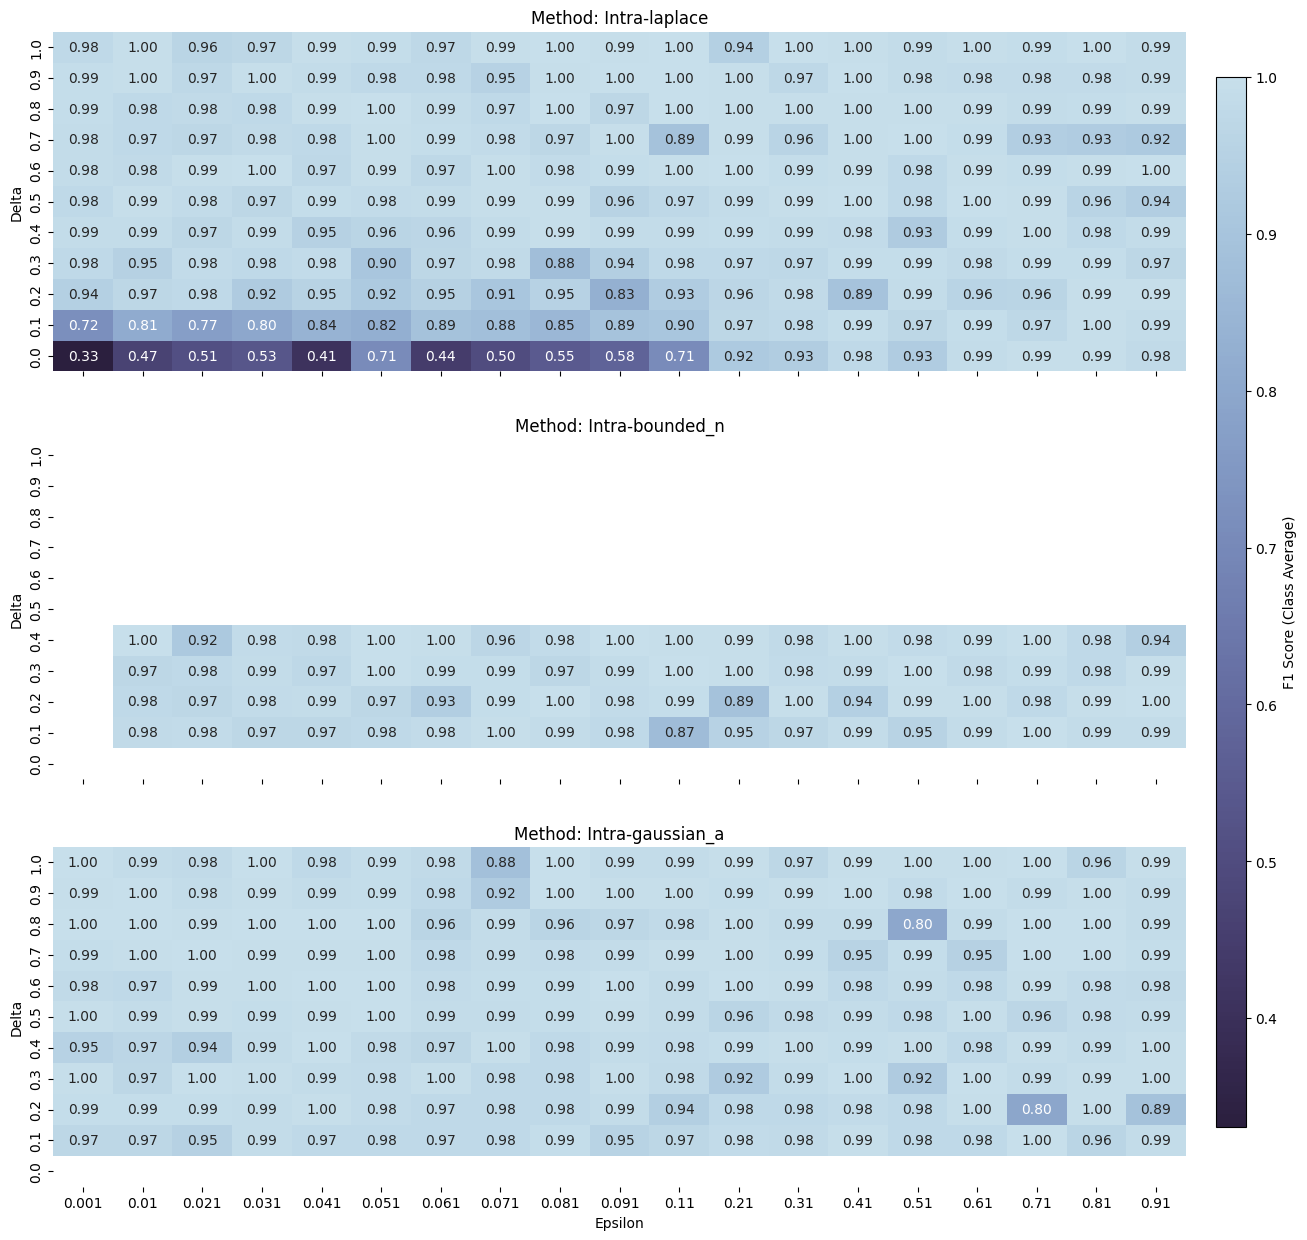

In [36]:
# Get unique Model, Epsilon and Delta
models = df_results_f1["Model"].unique()
epsilon_order = sorted(df_results_f1["Epsilon"].unique())
delta_order = sorted(df_results_f1["Delta"].unique(), reverse=True)

fig, axes = plt.subplots(len(models), 1, figsize=(15, 5 * len(models)), sharex=True)

# Normalize color scale across all models
vmin = df_results_f1["class_average"].min()
vmax = df_results_f1["class_average"].max()

from matplotlib.cm import ScalarMappable
import matplotlib as mpl
# cmap = sns.color_palette("light:#5A9_r", as_cmap=True)
cmap = sns.color_palette("ch:s=.25,rot=-.25_r", as_cmap=True)
# cmap = sns.color_palette("dark:#5A9", as_cmap=True)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)

for i, model in enumerate(models):
    model_df = df_results_f1[df_results_f1["Model"] == model]

    # Create pivot table for heatmap: rows = Delta, columns = Epsilon, values = class_average
    pivot_table = model_df.pivot_table(
        index="Delta",
        columns="Epsilon",
        values="class_average"
    ).reindex(index=delta_order, columns=epsilon_order)

    sns.heatmap(
        pivot_table,
        ax=axes[i],
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=False  # Disable individual colorbars
    )

    axes[i].set_title(f"Method: {model}")
    axes[i].set_ylabel("Delta")
    if i == len(models) - 1:
        axes[i].set_xlabel("Epsilon")
    else:
        axes[i].set_xlabel("")
        axes[i].set_xticklabels([]) 


plt.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(sm, cax=cbar_ax).set_label("F1 Score (Class Average)")

# plt.tight_layout()
plt.show()


#### per class

In [ ]:
# ---- Best per Class ----
# best_per_class = pd.concat([
#     df_results_f1.loc[df_results_f1[cls].idxmax()]
#     for cls in ["F", "N", "S", "V"]
# ], axis=1).T
# best_per_class

# top_k_per_class = {}
# for cls in ["F", "N", "S", "V"]:
#     top_k = df_results_f1.sort_values(by=cls, ascending=False).head(3)
#     top_k_per_class[cls] = top_k
# top_k_per_class



# ---- Worst per Class ----
# last_per_class = pd.concat([
#     df_results_f1.loc[df_results_f1[cls].idxmin()]
#     for cls in ["F", "N", "S", "V"]
# ], axis=1).T
# # last_per_class = pd.concat([

last_k_per_class = {}
for cls in ["N", "S", "V", "F"]:
    last_k = df_results_f1.sort_values(by=cls, ascending=True).head(3)
    last_k_per_class[cls] = last_k
# print(last_k_per_class['N'])
# print(last_k_per_class['S'])
# print(last_k_per_class['V'])
# print(last_k_per_class['F'])

In [ ]:
# print(last_k_per_class['N'])
# print(last_k_per_class['S'])
# print(last_k_per_class['V'])
print(last_k_per_class['F'])

                  Model  Epsilon  Delta    Metric         F         N  \
6929      Intra-laplace    0.061    0.0  f1_score  0.148148  0.948170   
7919      Intra-laplace    0.071    0.0  f1_score  0.166667  0.961799   
39779  Intra-gaussian_a    0.710    0.2  f1_score  0.236364  0.976023   

              S         V  class_average  
6929   0.070340  0.609668       0.444082  
7919   0.067416  0.805085       0.500242  
39779  0.977470  0.993711       0.795892  


### Comaparison of delta for epsilon = 0.01 ( for all mechanisms ) per class

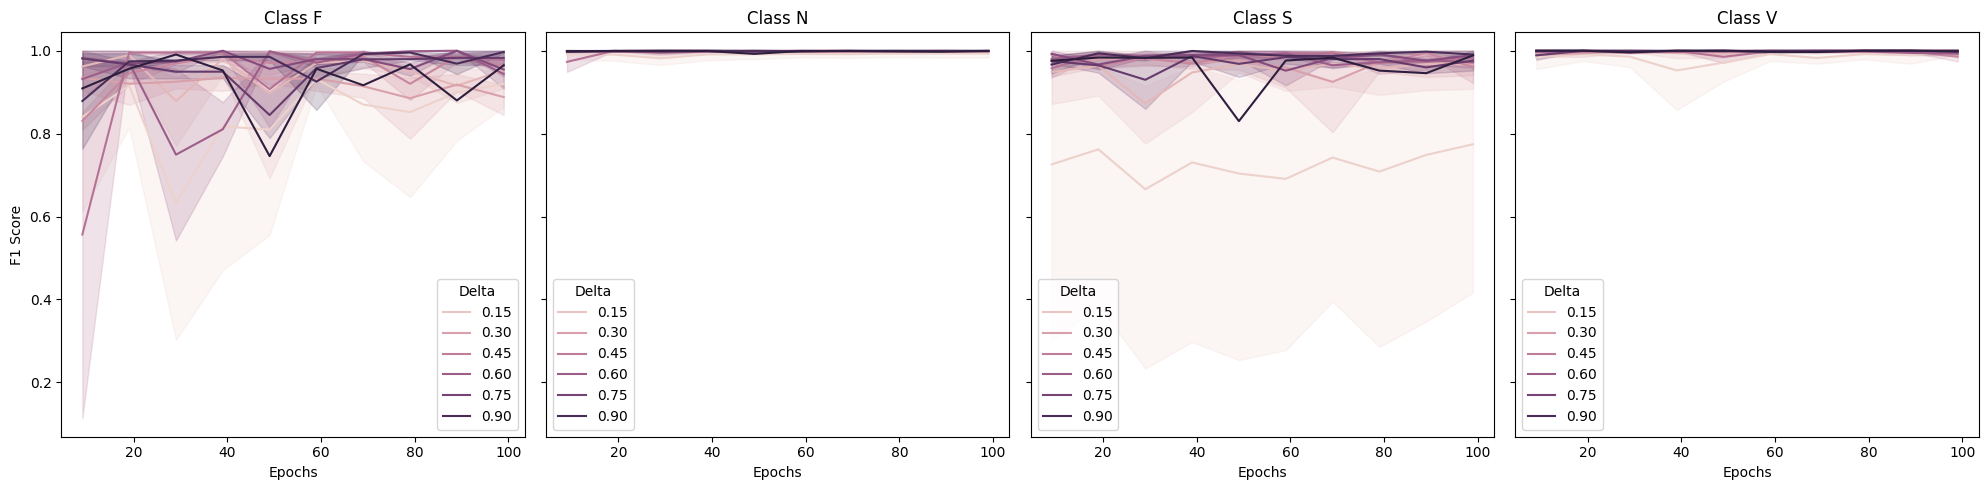

In [11]:
# Comparing F1 score of different deltas for each class

f1_epsilon = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epsilon"] == 0.01)]
classes = ["F", "N", "S", "V"]

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5), sharey=True)
for i, cls in enumerate(classes):
    sns.lineplot(
        data=f1_epsilon,
        x="Epoch",
        y=cls,
        hue="Delta",
        ax=axes[i]
    )
    axes[i].set_title(f"Class {cls}")
    axes[i].set_xlabel("Epochs")

axes[0].set_ylabel("F1 Score")
axes[-1].legend(title="Delta")

plt.tight_layout()
plt.show()

### F1 Score vs. Epochs -- by DP-Mechanism and Class

#### -- comparing delta for epsilon 0.01

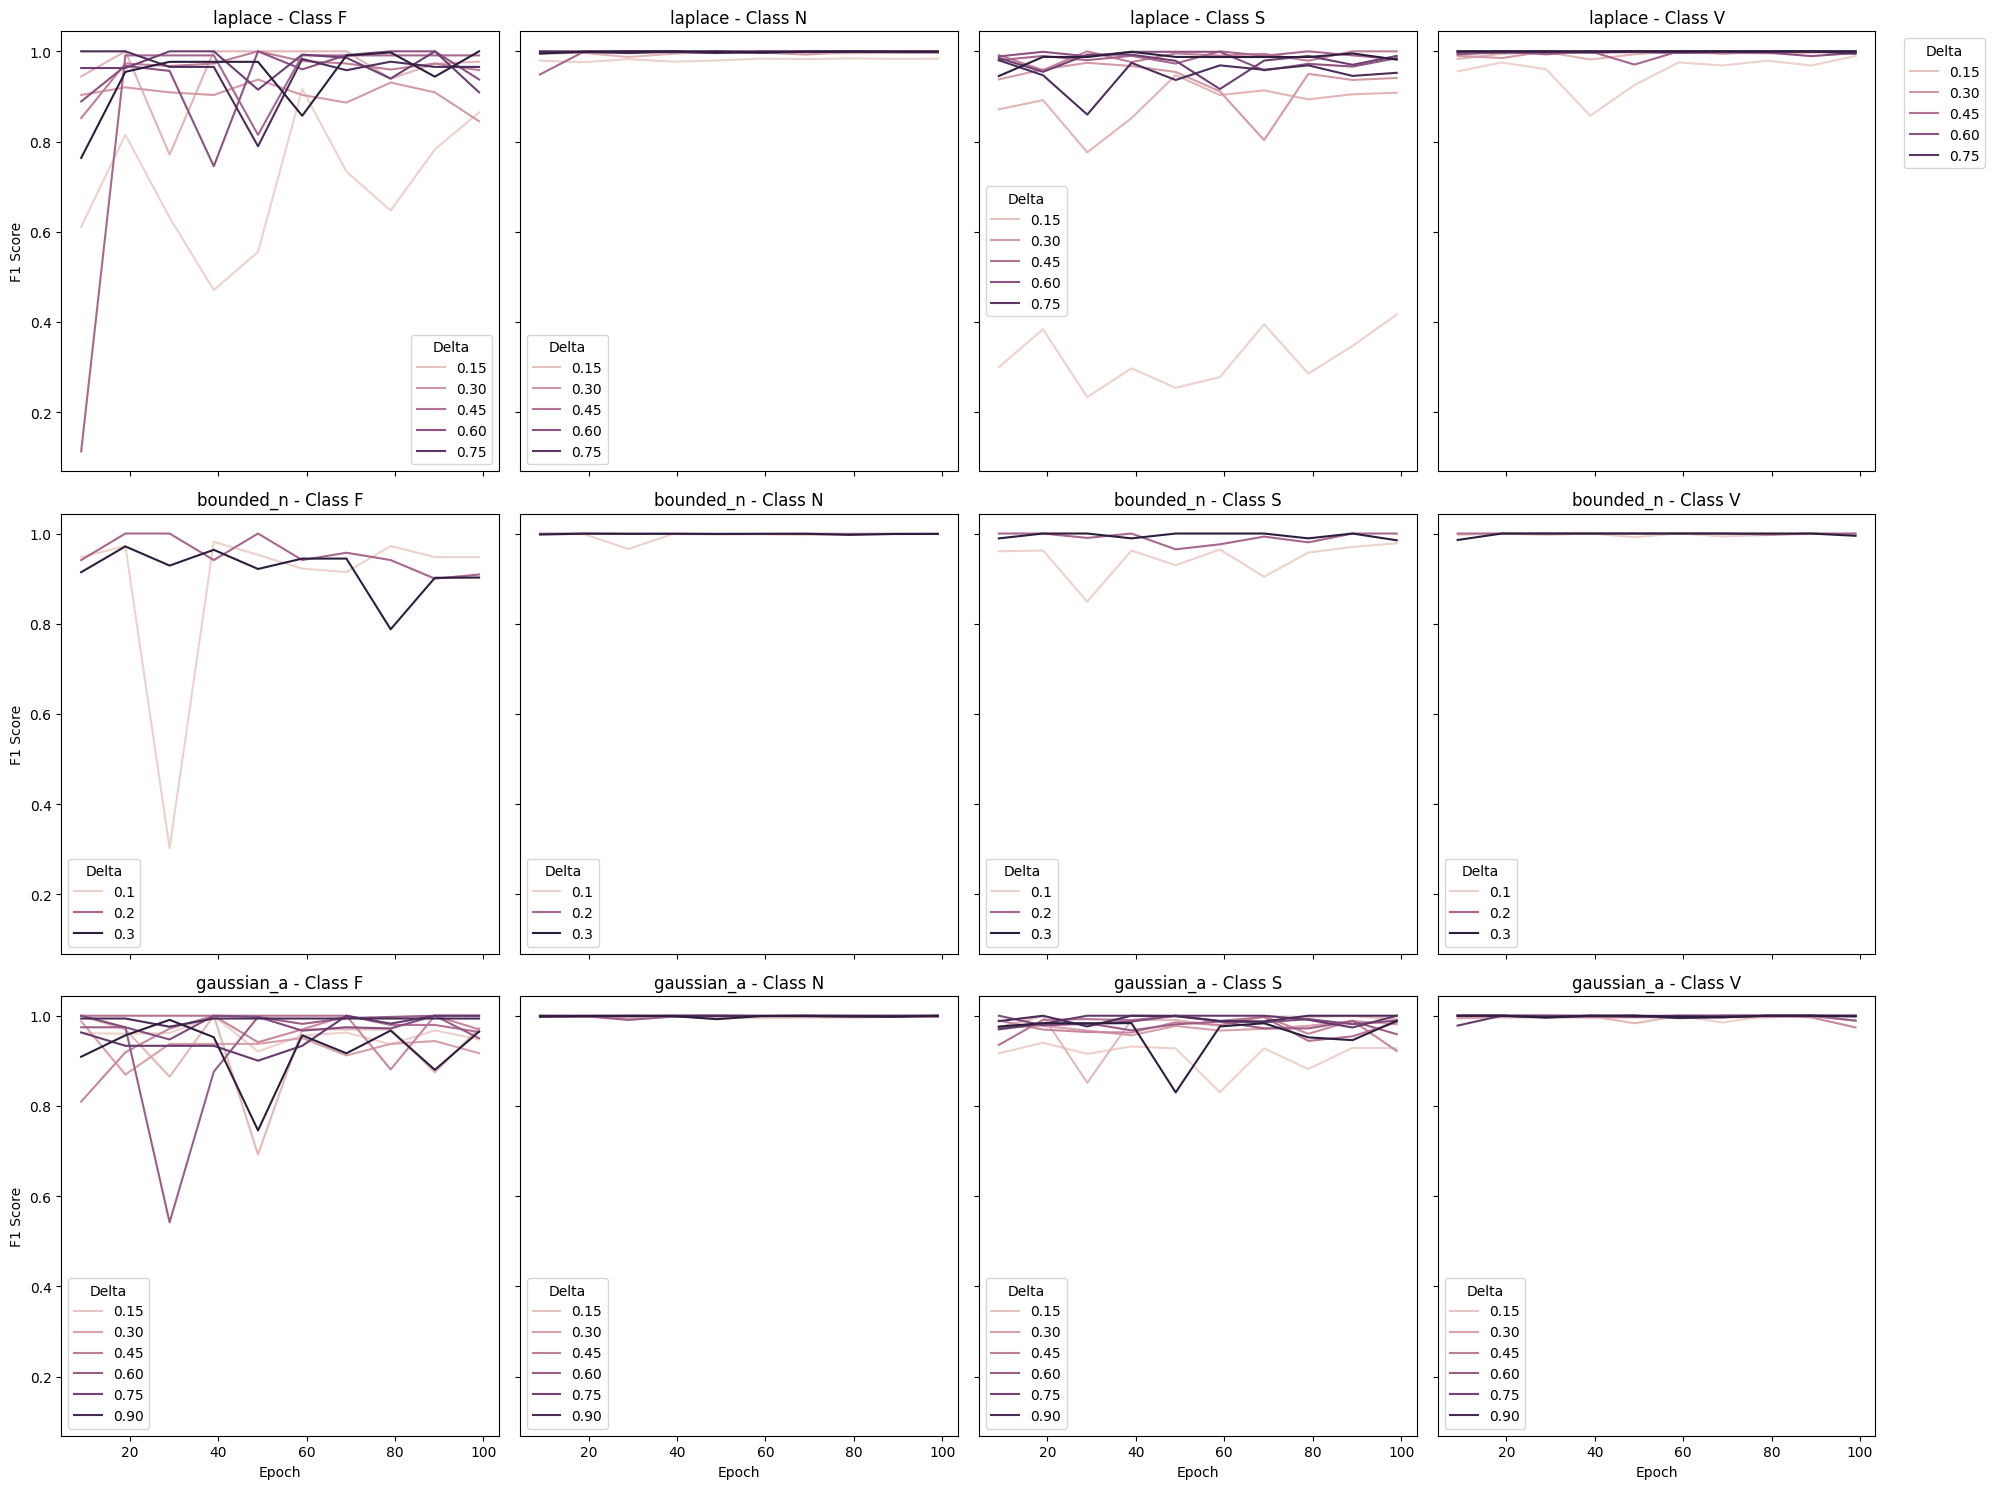

In [12]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epsilon"] == 0.01)]
classes = ["F", "N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Intra-{method}"]

        sns.lineplot(
            data=subset,
            x="Epoch",
            y=cls,
            hue="Delta",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")
        ax.set_xlabel("Epoch")
        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")

        if row_idx == 0 and col_idx == len(classes) - 1:
            ax.legend(title="Delta", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


#### -- comparing epsilon for delta 0.4

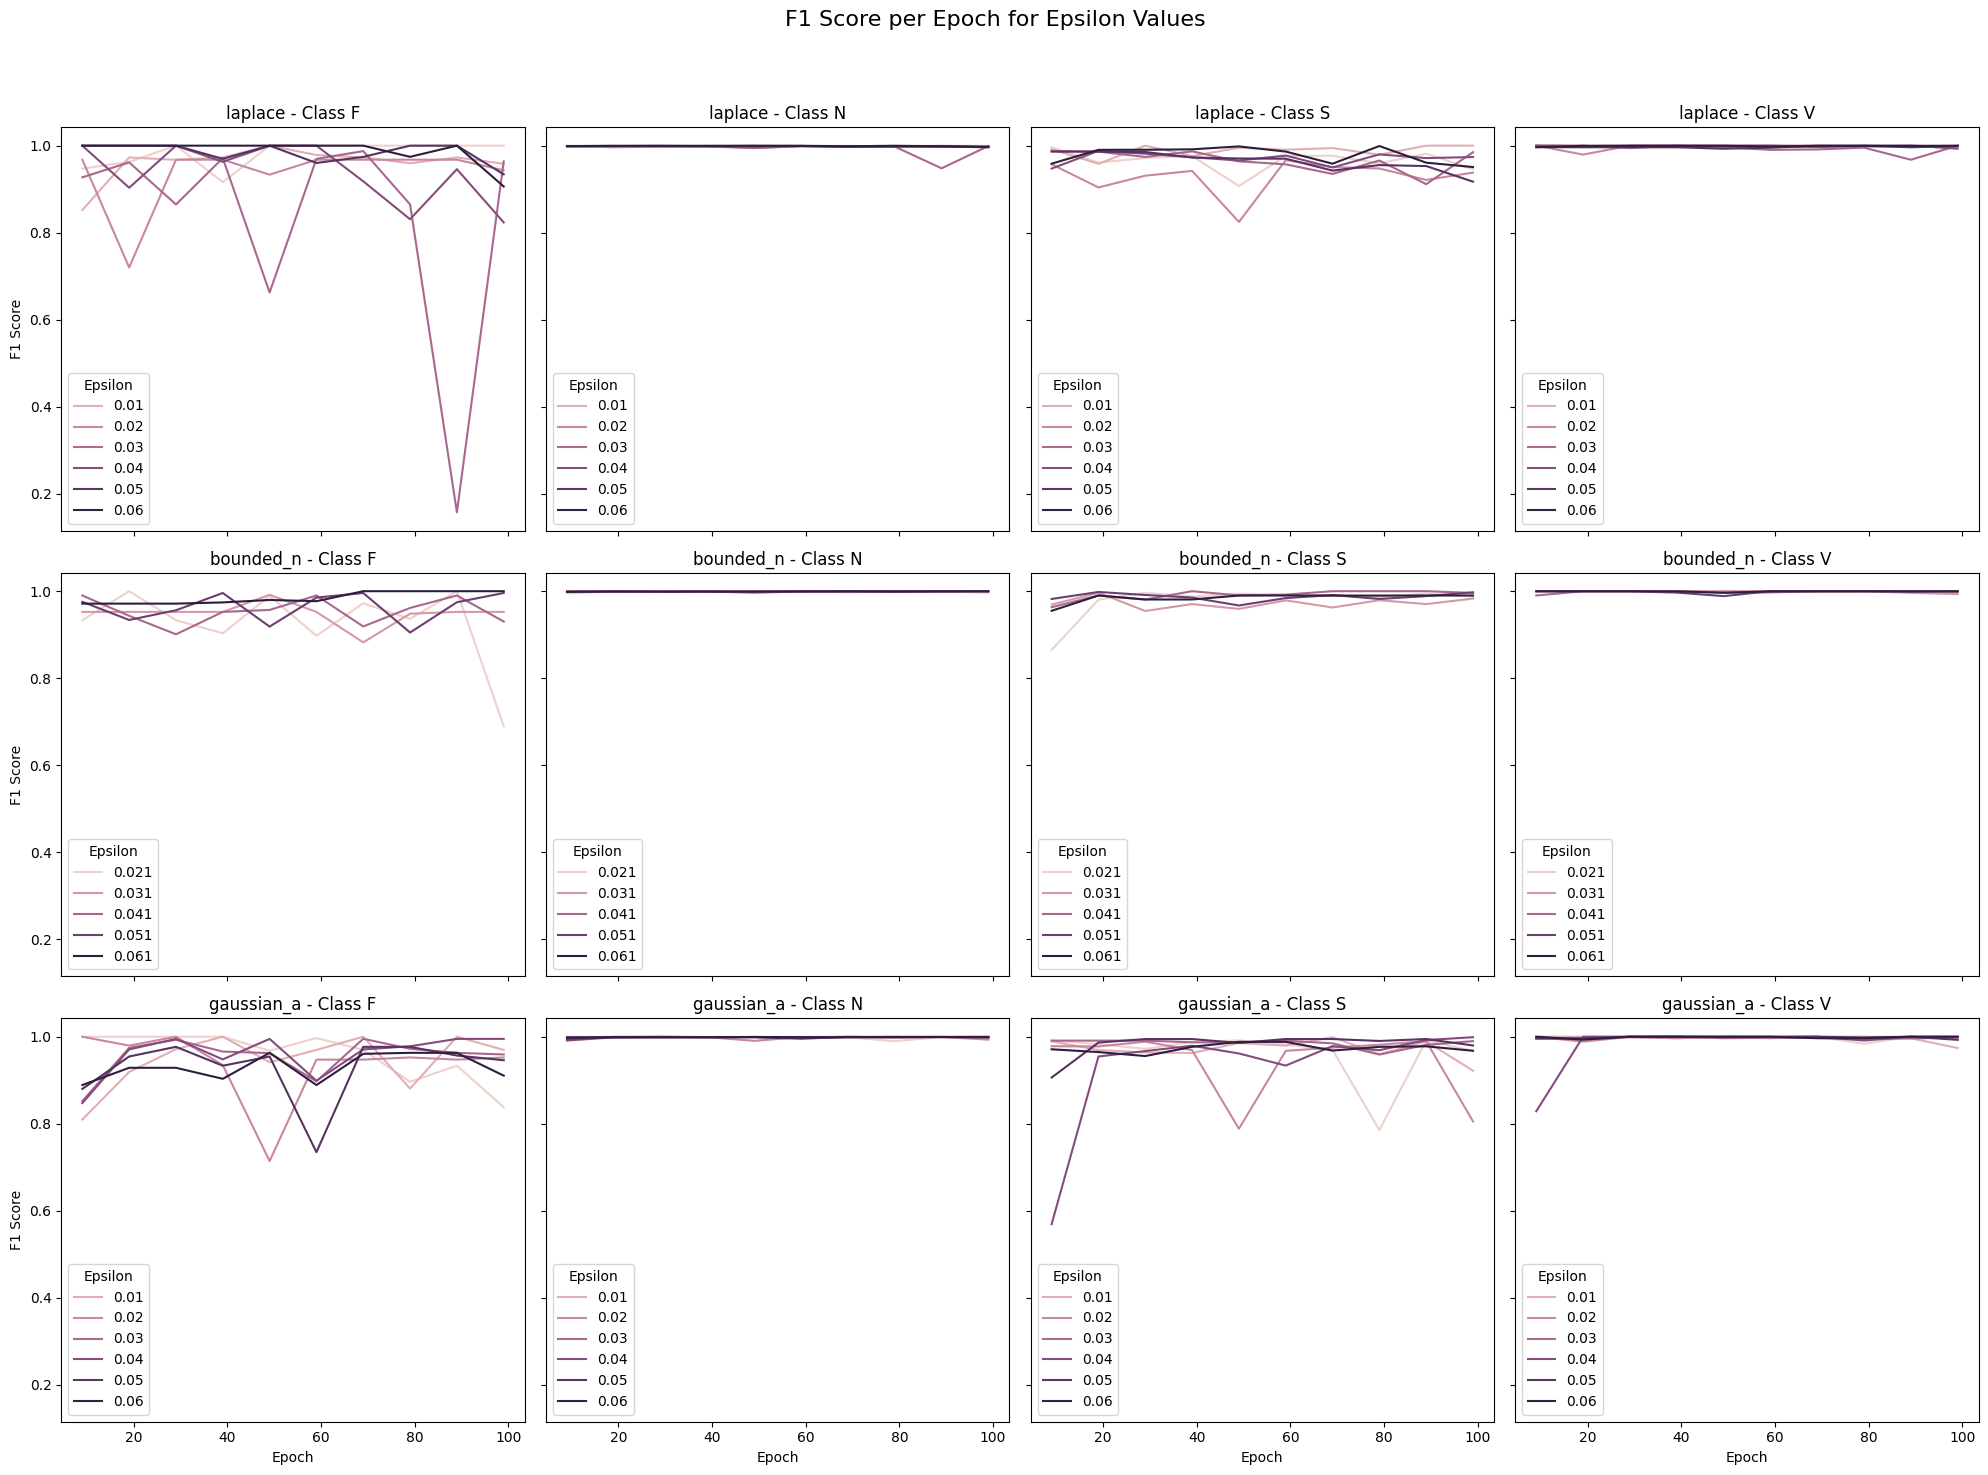

In [13]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Delta"] == 0.4)]
classes = ["F", "N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)
fig.suptitle(f"F1 Score per Epoch for Epsilon Values", fontsize=16)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Intra-{method}"]

        sns.lineplot(
            data=subset,
            x="Epoch",
            y=cls,
            hue="Epsilon",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")

        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")

        if row_idx == (len(dp_methods)-1):
            ax.set_xlabel("Epoch")
        else:
            ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### F1 Score vs. Epsilons/Deltas -- by DP Mechanism and Class (last epoch only)

#### -- comparing delta

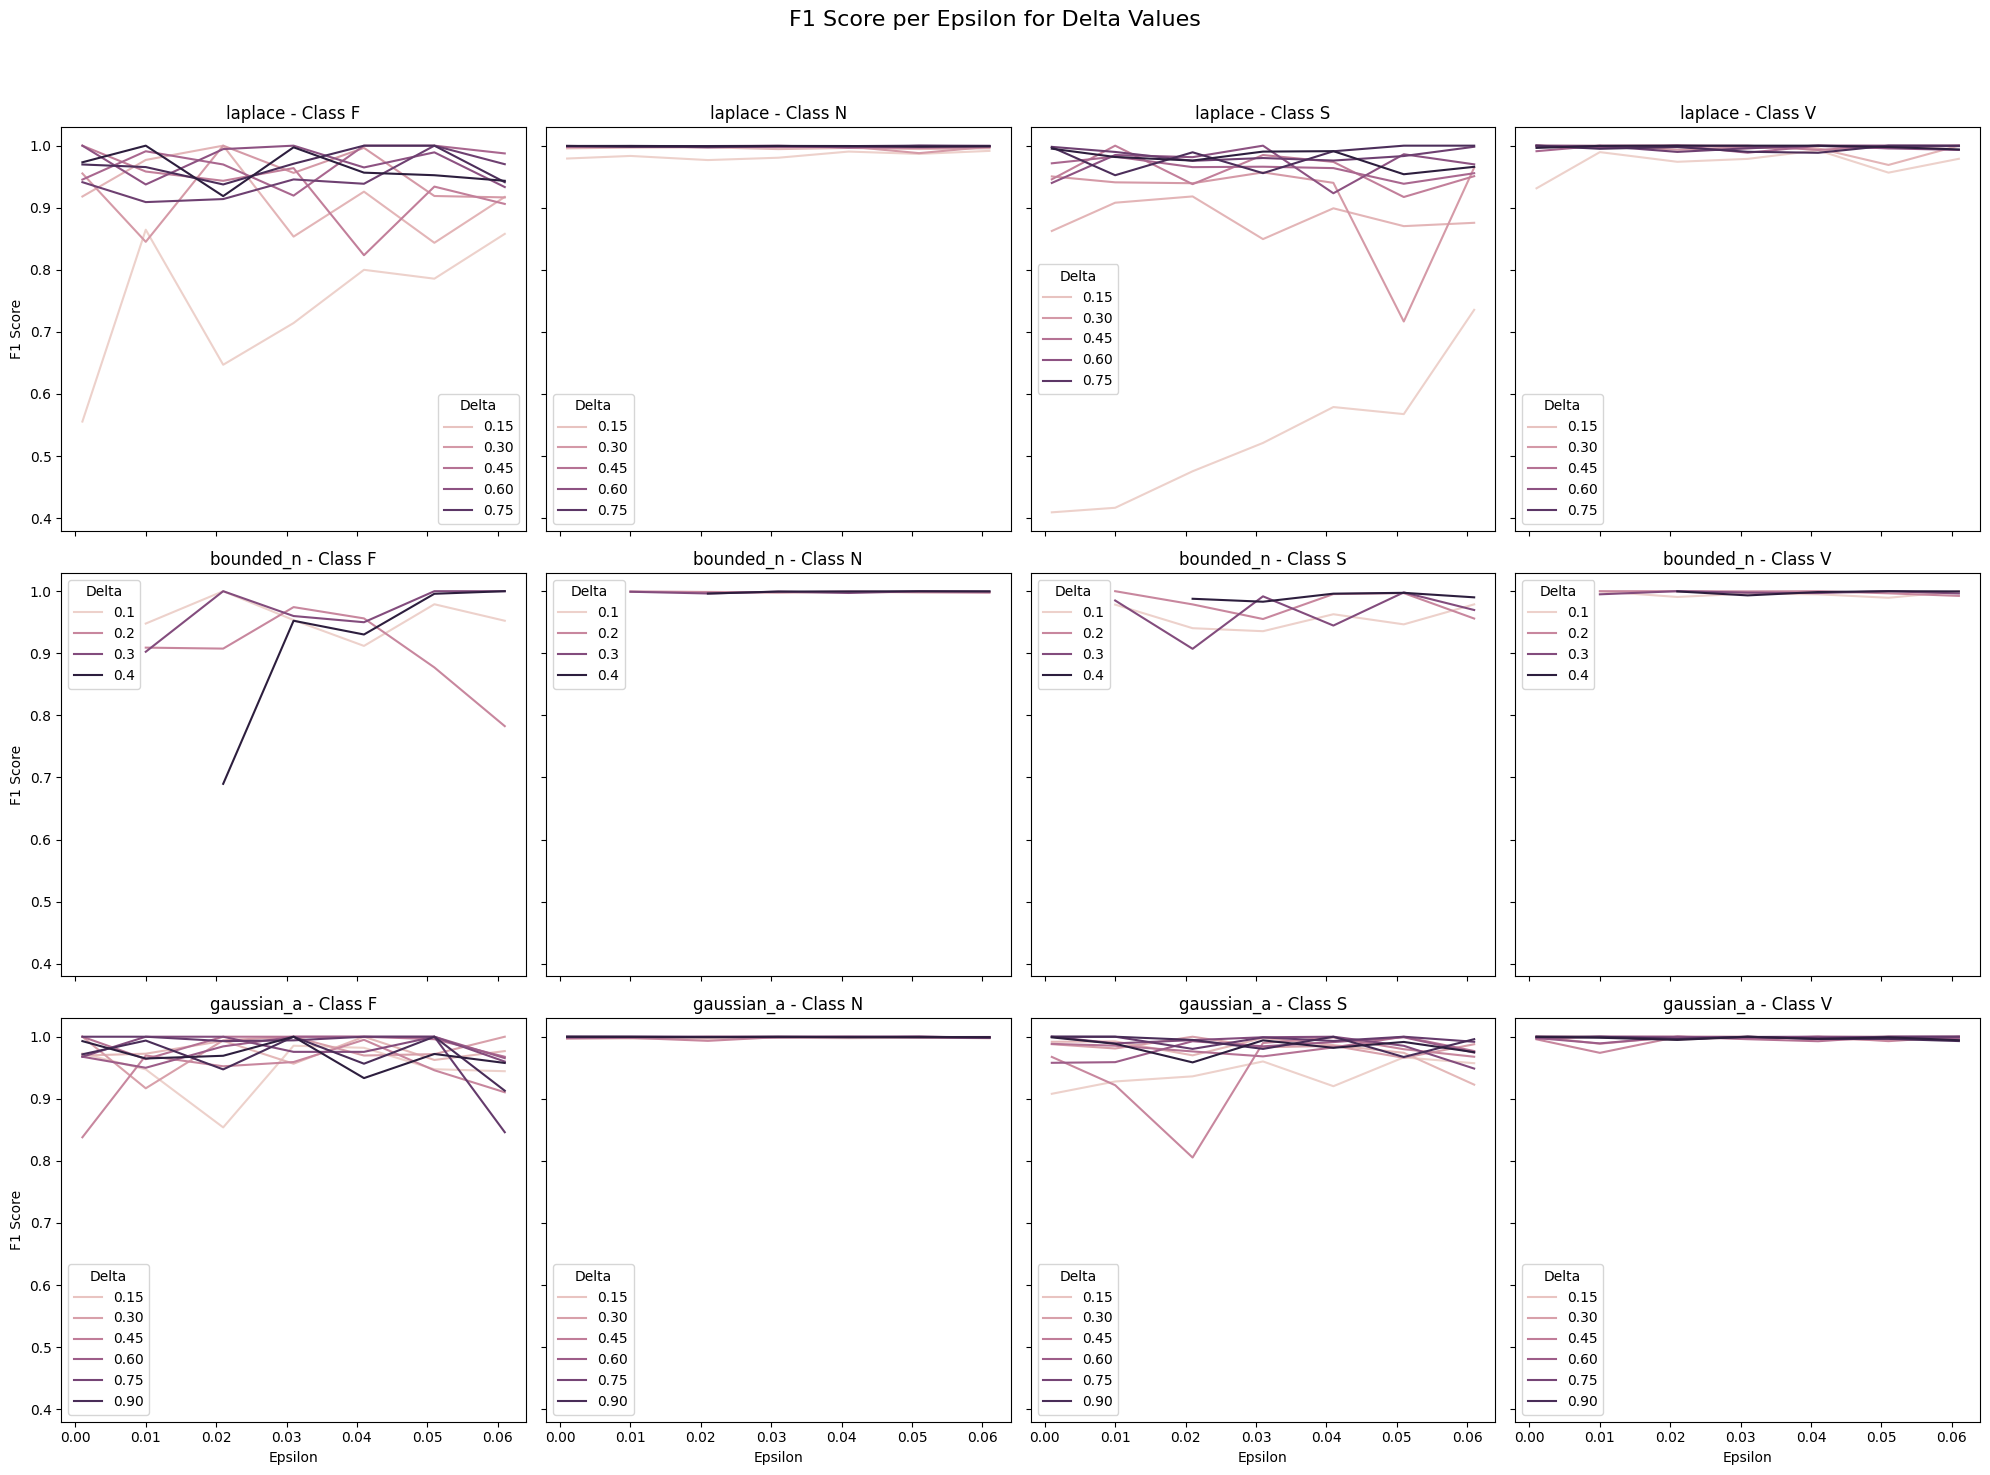

In [14]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
classes = ["F", "N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)
fig.suptitle(f"F1 Score per Epsilon for Delta Values", fontsize=16)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Intra-{method}"]

        sns.lineplot(
            data=subset,
            x="Epsilon",
            y=cls,
            hue="Delta",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")
        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### -- comparing epsilon 

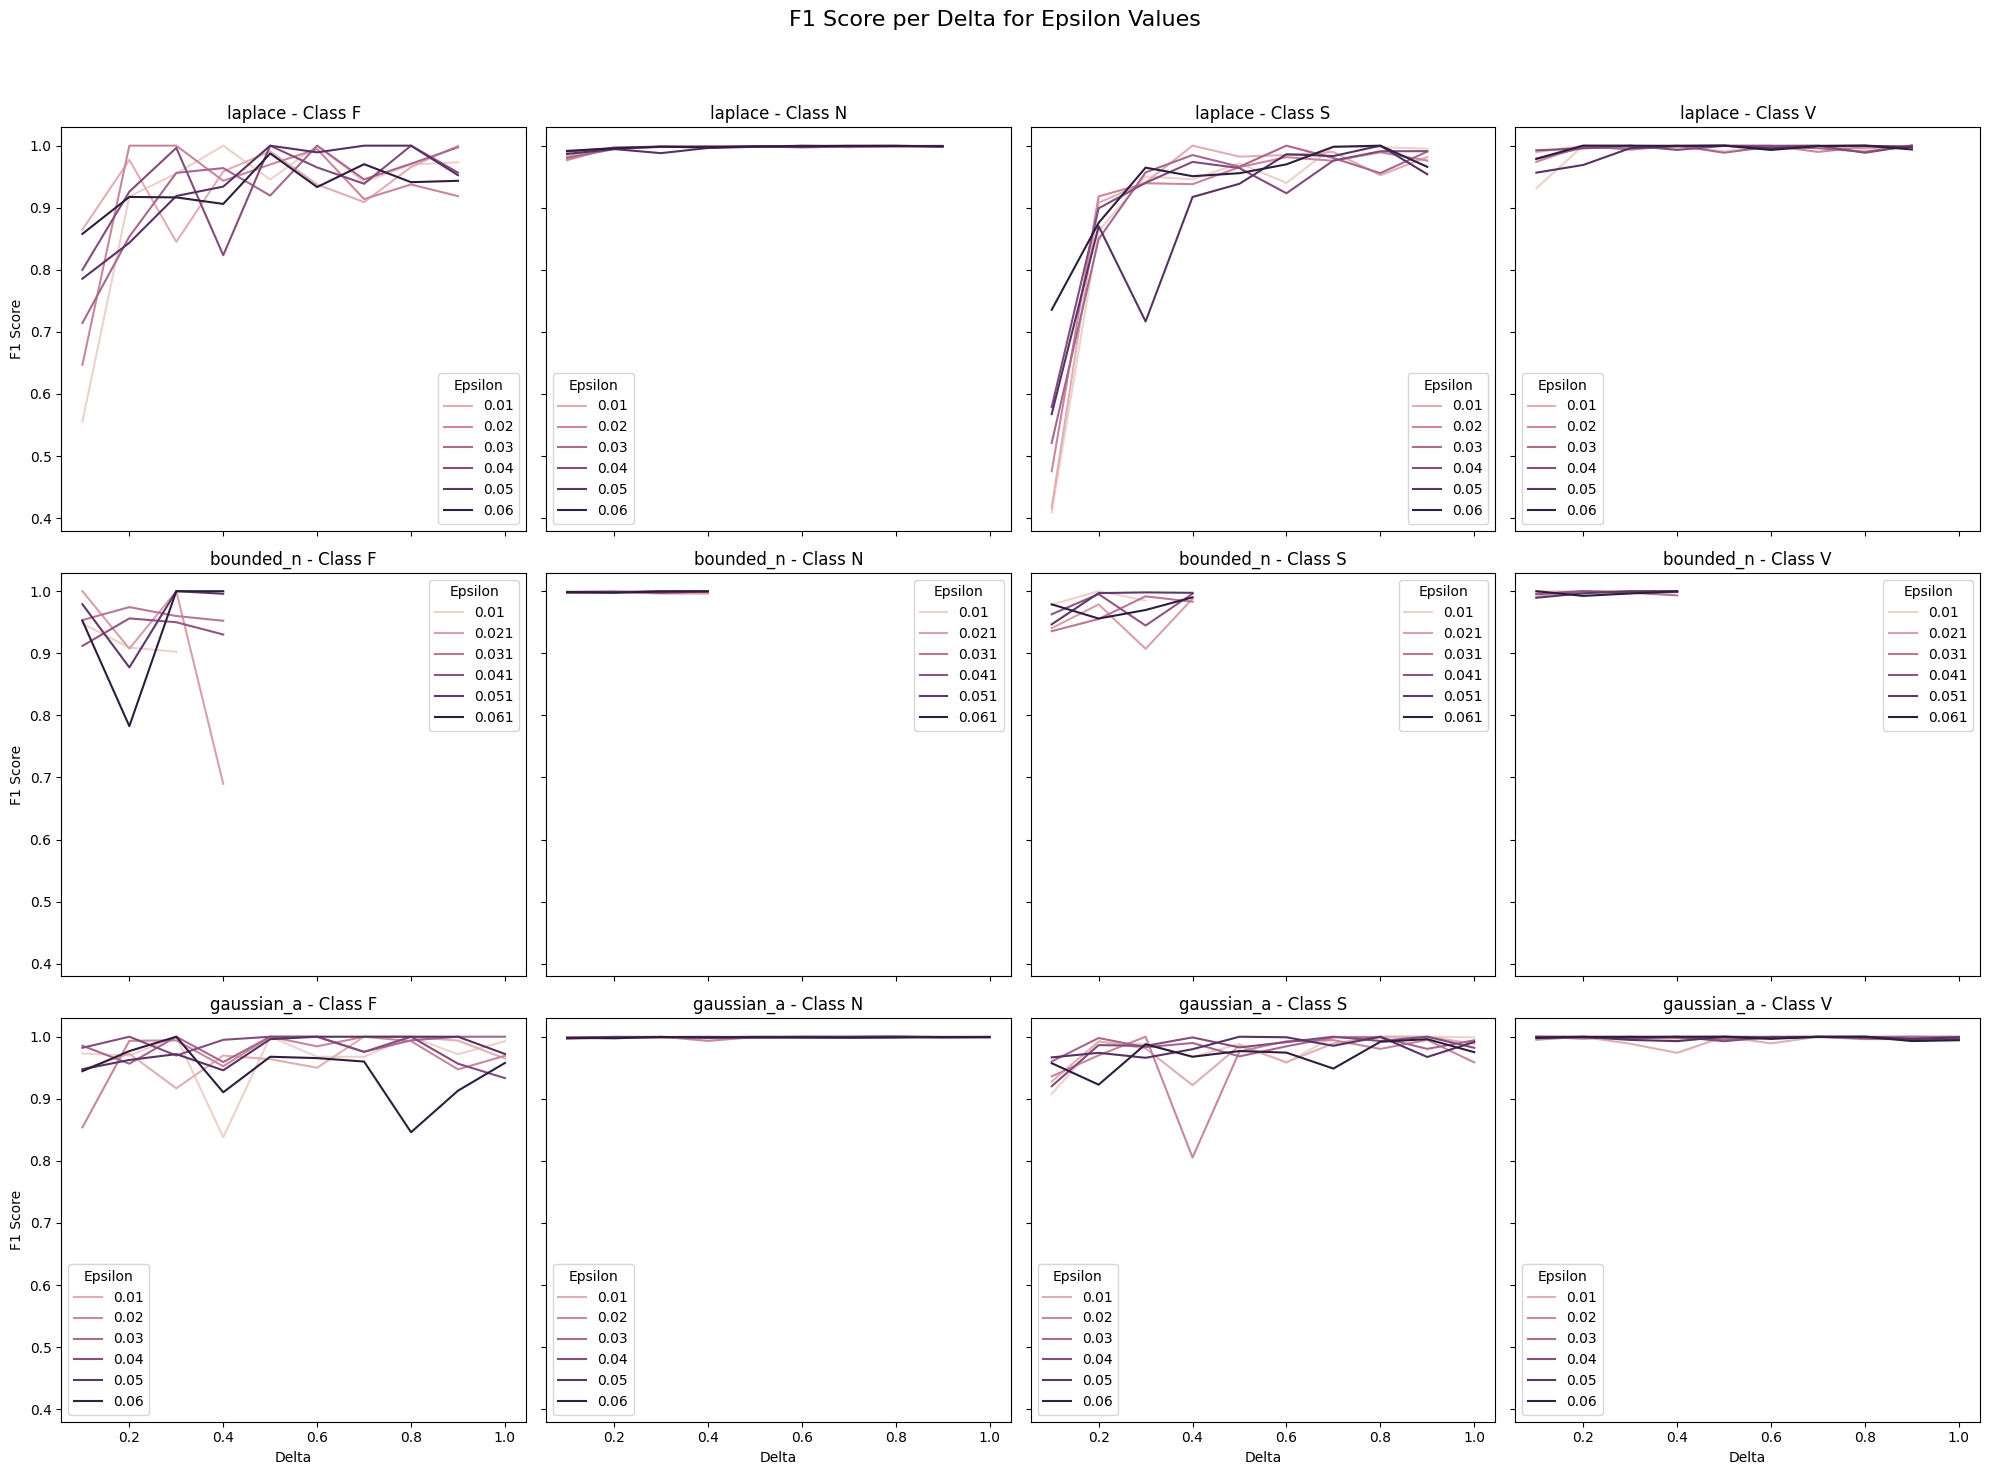

In [15]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
classes = ["F", "N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)
fig.suptitle(f"F1 Score per Delta for Epsilon Values", fontsize=16)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Intra-{method}"]

        sns.lineplot(
            data=subset,
            x="Delta",
            y=cls,
            hue="Epsilon",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")

        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")
        
        if row_idx == (len(dp_methods)-1):
            ax.set_xlabel("Delta")
        else:
            ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## F1 Scores

#### Max / Min per class

In [16]:
f1_last_epoch = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
max_f1_F = f1_last_epoch[f1_last_epoch["F"] == f1_last_epoch["F"].max()]
max_f1_N = f1_last_epoch[f1_last_epoch["N"] == f1_last_epoch["N"].max()]
max_f1_S = f1_last_epoch[f1_last_epoch["S"] == f1_last_epoch["S"].max()]
max_f1_V = f1_last_epoch[f1_last_epoch["V"] == f1_last_epoch["V"].max()]

max_f1_all = pd.concat([max_f1_F, max_f1_N, max_f1_S, max_f1_V], axis=0)

In [17]:
max_f1_F

,Model,Epsilon,Delta,Epoch,Metric,F,N,S,V,class_average
359,Intra-laplace,0.001,0.4,99,f1_score,1.0,0.998586,0.945802,1.000000,0.986097
539,Intra-laplace,0.001,0.6,99,f1_score,1.0,0.998605,0.939929,1.000000,0.984634
1619,Intra-laplace,0.010,0.9,99,f1_score,1.0,0.999585,0.981735,0.999664,0.995246
1799,Intra-laplace,0.021,0.2,99,f1_score,1.0,0.997353,0.918228,1.000000,0.978895
1889,Intra-laplace,0.021,0.3,99,f1_score,1.0,0.998381,0.939496,0.993502,0.982845
2969,Intra-laplace,0.031,0.6,99,f1_score,1.0,0.999890,1.000000,0.998505,0.999599
3689,Intra-laplace,0.041,0.5,99,f1_score,1.0,0.998944,0.963855,0.999669,0.990617
3959,Intra-laplace,0.041,0.8,99,f1_score,1.0,0.999302,0.990991,0.988543,0.994709
4499,Intra-laplace,0.051,0.5,99,f1_score,1.0,0.998117,0.938628,1.000000,0.984186
4679,Intra-laplace,0.051,0.7,99,f1_score,1.0,0.999557,0.983284,0.999653,0.995623


In [18]:
max_f1_all

,Model,Epsilon,Delta,Epoch,Metric,F,N,S,V,class_average
359,Intra-laplace,0.001,0.4,99,f1_score,1.000000,0.998586,0.945802,1.000000,0.986097
539,Intra-laplace,0.001,0.6,99,f1_score,1.000000,0.998605,0.939929,1.000000,0.984634
1619,Intra-laplace,0.010,0.9,99,f1_score,1.000000,0.999585,0.981735,0.999664,0.995246
1799,Intra-laplace,0.021,0.2,99,f1_score,1.000000,0.997353,0.918228,1.000000,0.978895
1889,Intra-laplace,0.021,0.3,99,f1_score,1.000000,0.998381,0.939496,0.993502,0.982845
...,...,...,...,...,...,...,...,...,...,...
12959,Intra-gaussian_a,0.051,0.8,99,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
13499,Intra-gaussian_a,0.061,0.4,99,f1_score,0.910506,0.998597,0.967742,1.000000,0.969211
13589,Intra-gaussian_a,0.061,0.5,99,f1_score,0.967742,0.998937,0.976909,1.000000,0.985897
13769,Intra-gaussian_a,0.061,0.7,99,f1_score,0.960000,0.998278,0.948693,1.000000,0.976743


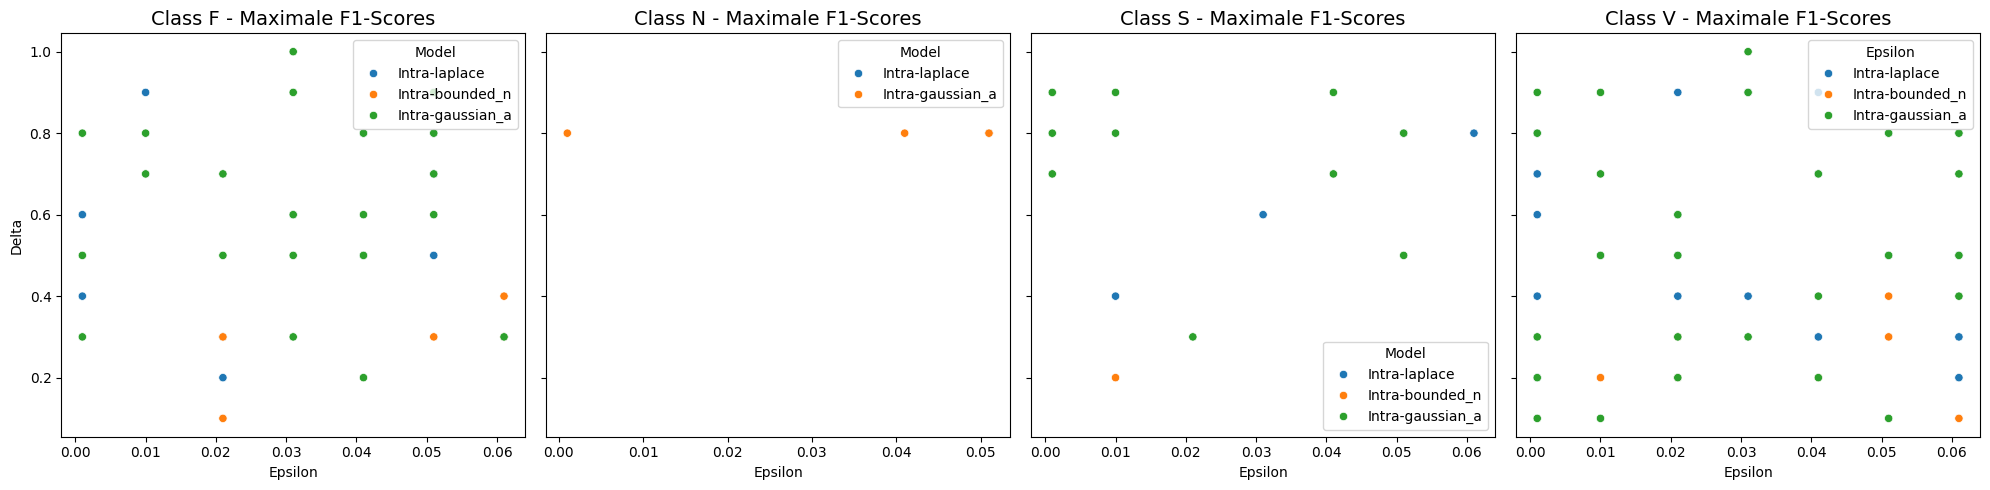

In [19]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
classes = ["F", "N", "S", "V"]

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5), sharey=True)

for i, cls in enumerate(classes):

    max_f1 = f1_results[f1_results[cls] == f1_results[cls].max()]
    sns.scatterplot(
        data=max_f1,
        x="Epsilon",
        y="Delta", 
        hue="Model",
        ax=axes[i]
    )
    axes[i].set_title(f"Class {cls} - Maximale F1-Scores", fontsize=14)
    axes[i].set_xlabel("Epsilon")

axes[0].set_ylabel("Delta")
axes[-1].legend(title="Epsilon")

plt.tight_layout()
plt.show()

#### Max / Min on average

In [20]:
f1_last_epoch_sorted = f1_last_epoch.sort_values(by=["class_average"], ascending=False)
top_10 = f1_last_epoch_sorted.head(10)
top_10

,Model,Epsilon,Delta,Epoch,Metric,F,N,S,V,class_average
8459,Intra-gaussian_a,0.001,0.8,99,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
12959,Intra-gaussian_a,0.051,0.8,99,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
4769,Intra-laplace,0.051,0.8,99,f1_score,1.000000,1.000000,1.000000,1.000000,1.000000
9359,Intra-gaussian_a,0.010,0.8,99,f1_score,1.000000,0.999945,1.000000,0.999300,0.999811
2969,Intra-laplace,0.031,0.6,99,f1_score,1.000000,0.999890,1.000000,0.998505,0.999599
7289,Intra-bounded_n,0.051,0.3,99,f1_score,1.000000,0.999945,0.998081,1.000000,0.999506
12779,Intra-gaussian_a,0.051,0.6,99,f1_score,1.000000,0.999917,0.999124,0.998612,0.999413
12689,Intra-gaussian_a,0.051,0.5,99,f1_score,0.996016,0.999945,1.000000,1.000000,0.998990
9809,Intra-gaussian_a,0.021,0.3,99,f1_score,0.994152,0.999945,1.000000,1.000000,0.998524
10169,Intra-gaussian_a,0.021,0.7,99,f1_score,1.000000,0.999860,0.994525,0.999681,0.998517


In [21]:
low_10 = f1_last_epoch_sorted.tail(10)
low_10

,Model,Epsilon,Delta,Epoch,Metric,F,N,S,V,class_average
4229,Intra-laplace,0.051,0.2,99,f1_score,0.843537,0.994543,0.870370,0.968931,0.919345
6299,Intra-bounded_n,0.021,0.4,99,f1_score,0.689655,0.996183,0.987793,0.999640,0.918318
4319,Intra-laplace,0.051,0.3,99,f1_score,0.918919,0.987949,0.716747,0.995972,0.904897
4949,Intra-laplace,0.061,0.1,99,f1_score,0.857909,0.991572,0.735528,0.978873,0.890970
3329,Intra-laplace,0.041,0.1,99,f1_score,0.800000,0.990497,0.578947,0.992481,0.840481
4139,Intra-laplace,0.051,0.1,99,f1_score,0.785714,0.986714,0.567568,0.956522,0.824129
899,Intra-laplace,0.010,0.1,99,f1_score,0.864629,0.983453,0.416667,0.989619,0.813592
2519,Intra-laplace,0.031,0.1,99,f1_score,0.714286,0.980566,0.521127,0.978723,0.798676
1709,Intra-laplace,0.021,0.1,99,f1_score,0.647059,0.976809,0.475483,0.974008,0.768340
89,Intra-laplace,0.001,0.1,99,f1_score,0.555556,0.979291,0.409332,0.931315,0.718874


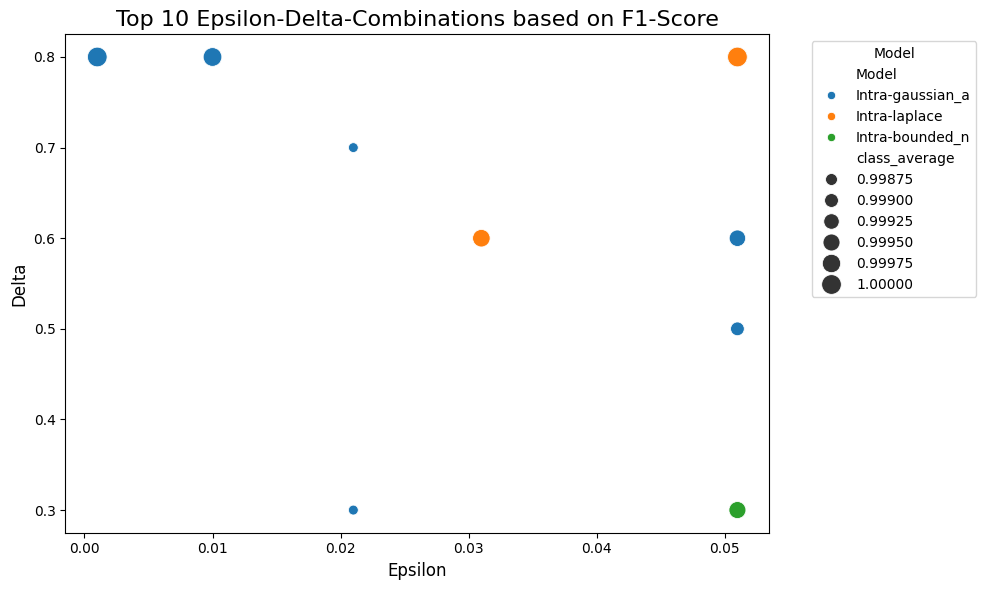

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top_10,
    x="Epsilon",
    y="Delta",
    hue="Model",
    size="class_average",
    sizes=(50, 200),
    palette="tab10"
)

# Achsentitel und Plot-Titel
plt.title("Top 10 Epsilon-Delta-Combinations based on F1-Score", fontsize=16)
plt.xlabel("Epsilon", fontsize=12)
plt.ylabel("Delta", fontsize=12)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

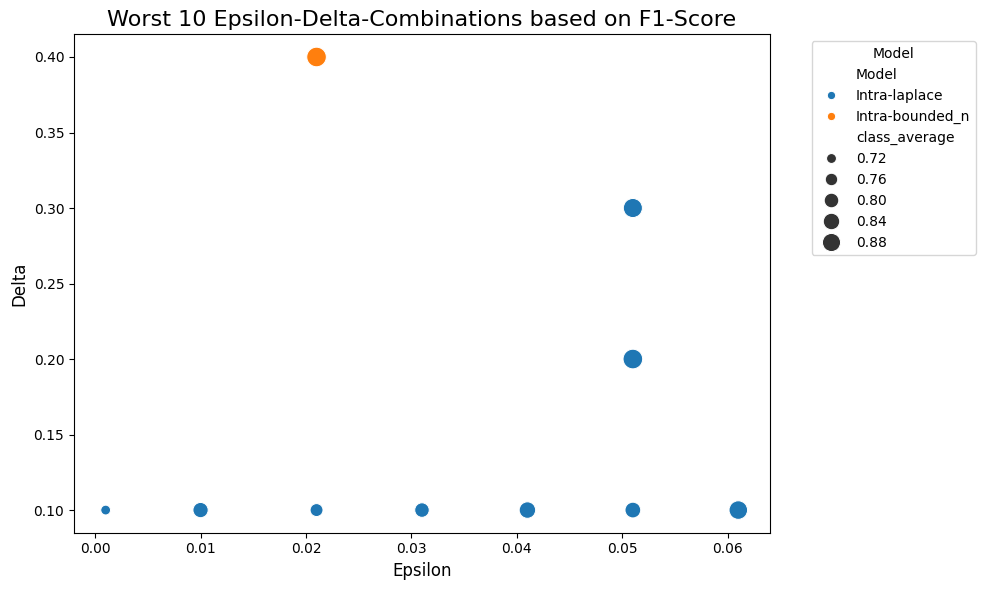

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=low_10,
    x="Epsilon",
    y="Delta",
    hue="Model",
    size="class_average",
    sizes=(50, 200),
    palette="tab10"
)

# Achsentitel und Plot-Titel
plt.title("Worst 10 Epsilon-Delta-Combinations based on F1-Score", fontsize=16)
plt.xlabel("Epsilon", fontsize=12)
plt.ylabel("Delta", fontsize=12)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [24]:
top_10.to_csv("../results_dp/intra_top_10.csv", index=False)

low_10.to_csv("../results_dp/intra_low_10.csv", index=False)